In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import warnings
import astropy.units as U
import astropy.constants as C
#from scipy.spatial.transform import Rotation as R
from numpy.linalg import eig
from numpy.linalg import eigh
from scipy.optimize import curve_fit, root
from scipy.spatial.transform import Rotation as R
from time import time

G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun

In [2]:
import argparse
import requests

In [3]:
#import illustris_python as il
import pts.simulation as sm
import pts.utils as ut
import pts.visual as vis
import pts.band as bd
import pts.do

In [4]:
def get(path, params=None, folderName=''):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        if filename.endswith('.hdf5'):
            file_access_property_list = h5py.h5p.create(h5py.h5p.FILE_ACCESS)
            file_access_property_list.set_fapl_core(backing_store=False)
            file_access_property_list.set_file_image(r.content)
            
            file_id_args = {
                'fapl': file_access_property_list,
                'flags': h5py.h5f.ACC_RDONLY,
                'name': next(tempfile._get_candidate_names()).encode()
            }
            
            h5_file_args = {'backing_store': False, 'driver': 'core', 'mode': 'r'}
            with contextlib.closing(h5py.h5f.open(**file_id_args)) as file_id:
                with h5py.File(file_id, **h5_file_args) as h5_file:
                    #return np.array(h5_file['grid'])
                    if 'grid' in h5_file.keys(): return np.array(h5_file['grid'])
                    else:
                        results = []
                        for k in h5_file.keys():
                            for sk in h5_file[k].keys():
                                results.append(np.array(h5_file[k][sk]))
                        return results
        else:
            with open(folderName + filename, 'wb') as f:
                f.write(r.content)
            return filename # return the filename string
    return r

In [5]:
def rotate(particles, velocities, theta = np.pi/2, rot_mat = None):
    if rot_mat is None:
        rot_mat = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
    particles_rot = particles @ rot_mat
    velocities_rot = velocities @ rot_mat
    return particles_rot, velocities_rot

In [6]:
def compute_rot_mat_angMom(subhalo_pos, coordinates, velocities, masses, Rmin = 0, Rmax = 20):
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    
    coordinates = np.delete(coordinates, indices, axis = 0)
    masses = np.delete(masses, indices)
    velocities = np.delete(velocities, indices, axis = 0)
    
    L = (np.cross(coordinates, velocities).T * np.array(masses)).T
    Lmean = np.mean(L, axis=0)
    #print(Lmean / np.linalg.norm(Lmean))
    
    rot, _ = R.align_vectors([Lmean, np.cross(Lmean, [1,0,0])], [[0,0,1],[1,0,0]])
    return rot.as_matrix(), Lmean

In [7]:
!ls ../data/particles/

halo_0_subhalo_0_eAbund.txt	    subhalo_0_eAbund.txt
halo_0_subhalo_0_gasCoord.txt	    subhalo_0_gasCoord.txt
halo_0_subhalo_0_gasDens.txt	    subhalo_0_gasDens.txt
halo_0_subhalo_0_gasHI.txt	    subhalo_0_gasHI.txt
halo_0_subhalo_0_gasHsml.txt	    subhalo_0_gasHsml.txt
halo_0_subhalo_0_gasMasses.txt	    subhalo_0_gasMasses.txt
halo_0_subhalo_0_gasMetal.txt	    subhalo_0_gasMetal.txt
halo_0_subhalo_0_gasVels.txt	    subhalo_0_gasVels.txt
halo_0_subhalo_0_intEne.txt	    subhalo_0_intEne.txt
halo_0_subhalo_0_starsCoord.txt     subhalo_0_starsCoord.txt
halo_0_subhalo_0_starsHsml.txt	    subhalo_0_starsHsml.txt
halo_0_subhalo_0_starsInitMass.txt  subhalo_0_starsInitMass.txt
halo_0_subhalo_0_starsMasses.txt    subhalo_0_starsMasses.txt
halo_0_subhalo_0_starsMetal.txt     subhalo_0_starsMetal.txt
halo_0_subhalo_0_starsSFT.txt	    subhalo_0_starsSFT.txt
halo_0_subhalo_0_starsVels.txt	    subhalo_0_starsVels.txt


In [8]:
data = h5py.File('../data/gals_properties.h5', 'a')

In [9]:
data.keys()

<KeysViewHDF5 ['MainProps', 'SubID_0']>

In [10]:
data['MainProps'][()].shape

(1, 17)

In [11]:
subIds = list(data.keys())[1:]

In [12]:
subIds

['SubID_0']

In [13]:
subID = 0#subIds[8][6:]
try:
    folder = '../data/TNGgalaxies/' + str(subID)
    os.mkdir(folder)
except:
    pass

In [14]:
int(subID)

0

In [15]:
data['SubID_' + str(subID) + '/Props'][()]

array([ 0.00000000e+00,  0.00000000e+00,  4.05637733e+14,  2.22719000e+00,
        8.97499262e+02,  1.25345586e+03,  3.88647771e+04,  2.70252436e+04,
        1.58496000e+01, -2.36392000e+02, -8.95239000e+01,  9.99385000e+02,
        4.83950399e+02,  6.99558606e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [16]:
particles = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsHsml.txt') / h # Hsml [kPc]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsInitMass.txt') * (1e10) / h # [Msun]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

stars_SFT = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_starsSFT.txt')

stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6

particles = np.hstack((particles, stars_t0.reshape(npart, 1)))

/tmp/ipykernel_3993660/2346750961.py:18: RuntimeWarning: invalid value encountered in power
  stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6


In [17]:
particles.shape

(4924218, 10)

In [18]:
# Discard wind particles (definition from illustris documentation: 
#      https://www.tng-project.org/data/docs/specifications/#parttype0
rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), particles[:,0:3], particles[:,4:7], particles[:,8], Rmax = 200)

ind_wind = np.where(stars_SFT <= 0)[0]
if len(ind_wind) > 0:
    particles = np.delete(particles, ind_wind, axis=0)

# Rotate to be edge-on: (SKIRT is observing from z axis, i.e, it observe the plane x-y)

theta = np.pi/2
particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                            theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                            theta = theta) # This put the AM in the z-axis

# Separare old from young stars:

# from where do we get this formula???

# from where do we get this condition???

ind_old = np.where(particles[:,9] > 1e-2)[0]
ind_new = np.where(particles[:,9] <= 1e-2)[0]

particles_old = particles[ind_old]
particles = particles[ind_new]

if len(ind_old) > 0:
    stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    #stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) +  \
    #                   ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family' + \
    #                   '\n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc)' + \
    #                   '\n Column 4: particle smoothing length (kpc)' +  \
    #                   '\n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    np.savetxt(folder + '/stars_old_v.txt', particles_old, header = stars_old_header)
    
if len(ind_new) > 0:
    log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
    P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
    ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
    particles[:,7] = particles[:,7] / particles[:,9] * 1e9 # I dont know why we do this
    
    particles = np.hstack((particles, log10C, P, ccf))
    stars_sb_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: star formation rate (Msun/yr) \n Column 9: metallicity (1) \n Column 10: compactness (1) \n Column 11: pressure (K/m3) \n Column 12: cloud covering fraction (1) \n'

    np.savetxt(folder + '/stars_sb_v.txt', particles, header = stars_sb_header)

In [82]:
particles = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasDens.txt') * (1e10) * (h**2) # [Msun / kPc^3]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

#stars_SFT = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasSFT.txt')

#aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasHsml.txt') / h # Hsml [kPc]
#particles = np.hstack((particles, aux.reshape(npart, 1)))

# Rotate data to be edge-on
particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                            theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                            theta = theta) # This put the AM in the x-axis

# Let's save the data
particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
gas_header = ' Gas particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a medium source using M_dust = f_dust x Z x M_gas \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: gas mass volume density (Msun/pc3) \n Column 5: metallicity (1) \n Column 6: x-velocity (km/s) \n Column 7: y-velocity (km/s) \n Column 8: z-velocity (km/s) \n '
np.savetxt(folder + '/gas_v.txt', particles, header = gas_header)
  

In [20]:
particles.shape

(8979479, 8)

# SKIRT

In [22]:
n_px = 128 # Number of pixels
D = 15 # Distance to galaxy [Mpc]
FoV = 17.2 # Field of view [minutes]
px_s = 17.2 / n_px # Pixel size [minutes] 
FoV_phys = FoV * (1/60) * (np.pi / 180) * D * 1e6 # physical distance at observer [Pc]
Rmax = int(0.5 * n_px * D * 1e3 * px_s * 4.848e-6)
print("Rmax: ", Rmax)
#self.get_data(subID, snapID, rot, folder, Rmax)
Rframe = Rmax * 1e3 # [Pc]
#Rsource1 = 0.5 * Rframe
#Rsource2 = 0.1 * Rframe
Rmedium = FoV_phys#0.5 * Rframe * 1e6 # pc
Rgrid = 0.5 * Rframe
#print(Rmax)
#Rmax = 14.961969356639141
#Rmax = 0.5 * Rframe
#Rsource1 = Rmax
#Rsource2 = Rmax
#Rmedium = Rmax
#Rgrid = Rmax

skifile = sm.SkiFile('template.ski')
#skifile = sm.SkiFile('template_sb-sph.ski')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minX', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxX', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minY', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxY', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minZ', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minX', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxX', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minY', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxY', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minZ', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minX', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxX', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minY', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxY', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minZ', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxZ', str(Rsource2) + ' pc')

skifile.setStringAttribute('.//ParticleSource', 'filename', 'stars_old_v.txt')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'filename', 'gas_v.txt')

skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')

#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minX', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxX', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minY', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxY', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minZ', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxZ', str(Rgrid) + ' pc')

skifile.setNumPrimaryPackets(2e7)
skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
#skifile.setStringAttribute('.//FrameInstrument', 'inclination', '90 deg')
#skifile.setStringAttribute('.//FrameInstrument', 'azimuth', '180 deg')
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(100000) + ' pc')
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(100000) + ' pc')

skifile.saveTo(folder + '/galaxy.ski')

Rmax:  0


In [42]:
skirt = sm.Skirt()
simulation = skirt.execute(folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief

07/11/2024 15:29:21.865   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
07/11/2024 15:29:21.865   Running on coglians.phys.sissa.it for mdelosri
07/11/2024 15:29:21.867   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/TNGgalaxies/5/galaxy.ski'...
07/11/2024 15:29:48.492 - Finished setup in 26.4 s.
07/11/2024 15:29:48.492 - Finished setup output in 0.0 s.
07/11/2024 15:30:09.318 - Finished primary emission in 20.8 s.
07/11/2024 15:30:16.352 - Finished secondary emission in 7.0 s.
07/11/2024 15:30:16.352 - Finished the run in 27.9 s.
07/11/2024 15:30:21.143 - Finished final output in 4.8 s.
07/11/2024 15:30:21.143 - Finished simulation galaxy using 4 threads and a single process in 59.0 s.
07/11/2024 15:30:21.213   Available memory: 125 GB -- Peak memory usage: 10.5 GB (8.3%)


In [43]:
SDSS_U = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_U_BroadBand.stab')
SDSS_G = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_G_BroadBand.stab')
SDSS_R = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_R_BroadBand.stab')
SDSS_I = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_I_BroadBand.stab')
SDSS_Z = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_Z_BroadBand.stab')


In [44]:
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)


(<Quantity 1.e-05 MJy / sr>, <Quantity 1000. MJy / sr>)

In [45]:
folder

'../data/TNGgalaxies/5'

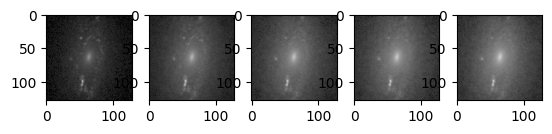

In [46]:
# Load the image
imgU = mpimg.imread(folder + "/galaxy_cube_total_SDSS_U.png")
imgG = mpimg.imread(folder + "/galaxy_cube_total_SDSS_G.png")
imgR = mpimg.imread(folder + "/galaxy_cube_total_SDSS_R.png")
imgI = mpimg.imread(folder + "/galaxy_cube_total_SDSS_I.png")
imgZ = mpimg.imread(folder + "/galaxy_cube_total_SDSS_Z.png")

# Display the image
fig,ax = plt.subplots(1,5)
ax[0].imshow(imgU)
ax[1].imshow(imgG)
ax[2].imshow(imgR)
ax[3].imshow(imgI)
ax[4].imshow(imgZ)

# Martini

In [21]:
import martini

In [22]:
martini.__version__

'2.1.6'

In [23]:
from martini.sources import TNGSource, SPHSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel, find_fwhm
import astropy.units as U
from Hdecompose.atomic_frac import atomic_frac

In [24]:
source = TNGSource(
    'TNG100-1',
    99,
    0,
    api_key='81b7c70637fa8b110e6b9f236ea07c37',
    cutout_dir=".",
    distance=15 * U.Mpc,
    rotation={"rotmat": np.eye(3)},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

Using local cutout file martini-cutout-TNG100-1-99-0.hdf5


In [25]:
dir(source)

['T_g',
 '_X_H_g',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fatomic_g',
 '_init_pixcoords',
 '_init_skycoords',
 '_mu_g',
 '_nH_g',
 '_rho_g',
 'apply_mask',
 'boost',
 'coordinate_frame',
 'coordinates_g',
 'current_rotation',
 'dec',
 'distance',
 'h',
 'hsm_g',
 'input_mass',
 'mHI_g',
 'npart',
 'pixcoords',
 'preview',
 'ra',
 'rotate',
 'save_current_rotation',
 'skycoords',
 'spectralcoords',
 'translate',
 'vhubble',
 'vpeculiar',
 'vsys']

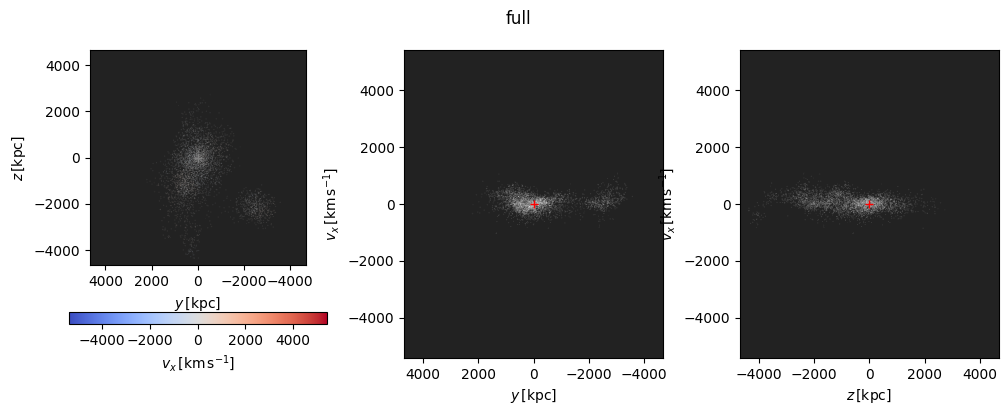

In [47]:
source.preview(title="full")
plt.show()

In [83]:
subID=0
a = 1 #data_header["Time"]
z = 0 #data_header["Redshift"]
#h = data_header["HubbleParam"]
xe_g = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_eAbund.txt') #data_g["ElectronAbundance"]
#%rho_g = particles[:,3] * U.Msun * np.power(U.kpc, -3) #data_g["Density"] * 1e10 / h * U.Msun * np.power(a / h * U.kpc, -3)
rho_g = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasDens.txt') * (1e10) * (h**2) * U.Msun * np.power(U.kpc, -3)
u_g = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_intEne.txt') # data_g["InternalEnergy"] [km/s^2]  # unit conversion handled in T_g
X_H_g = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasHI.txt') # GFM_Metals[:,0] HI
mu_g = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
#%mu_g = 4 * C.m_p.to(U.g).value / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
T_g = (
    (gamma - 1)
    * u_g
    / C.k_B.to_value(U.erg / U.K)
    * 1e10
    * mu_g
    * U.K
    * C.m_p.to_value(U.g)
)
m_g = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasMasses.txt') * U.Msun # data_g["Masses"] * 1e10 / h * U.Msun
            # cast to float64 to avoid underflow error
nH_g = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p
            # In TNG_corrections I set f_neutral = 1 for particles with density
            # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
            # tables for TNG will be available soon anyway.
fatomic_g = atomic_frac(
    z,
    nH_g,
    T_g,
    rho_g,
    X_H_g,
    mu=mu_g,
    onlyA1=True,
    TNG_corrections=True,
)
mHI_g = m_g * X_H_g * fatomic_g

xyz_g = particles[:,0:3] * U.kpc
vxyz_g = particles[:,5:8] * U.km / U.s
V_cell = (
    m_g / rho_g
)  # Voronoi cell volume
r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
# hsm_g has in mind a cubic spline that =0 at r=h, I think
hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)

(array([8.975104e+06, 4.290000e+02, 3.190000e+02, 3.230000e+02,
        3.490000e+02, 3.930000e+02, 4.520000e+02, 5.090000e+02,
        6.780000e+02, 9.230000e+02]),
 array([1.51863361e-11, 9.60558438e-02, 1.92111688e-01, 2.88167531e-01,
        3.84223375e-01, 4.80279219e-01, 5.76335063e-01, 6.72390906e-01,
        7.68446750e-01, 8.64502594e-01, 9.60558438e-01]),
 <BarContainer object of 10 artists>)

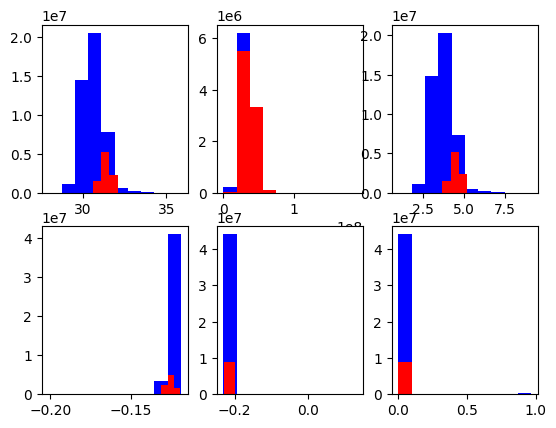

In [84]:
fig,ax = plt.subplots(2,3)

ax[0,0].hist(np.log10(source._nH_g.value), color = 'blue')
ax[0,0].hist(np.log10(nH_g.value), color = 'red')

ax[0,1].hist((source.T_g.value), color = 'blue')
ax[0,1].hist((T_g.value), color = 'red')

ax[0,2].hist(np.log10(source._rho_g.value), color = 'blue')
ax[0,2].hist(np.log10(rho_g.value), color = 'red')

ax[1,0].hist(np.log10(source._X_H_g), color = 'blue')
ax[1,0].hist(np.log10(X_H_g), color = 'red')

ax[1,1].hist(np.log10(source._mu_g), color = 'blue')
ax[1,1].hist(np.log10(mu_g), color = 'red')

ax[1,2].hist((source._fatomic_g.value), color = 'blue')
ax[1,2].hist((fatomic_g.value), color = 'red')

(array([1.405790e+05, 8.185447e+06, 6.480330e+05, 3.560000e+02,
        4.900000e+01, 7.300000e+01, 8.500000e+01, 5.000000e+00,
        8.340000e+02, 4.018000e+03]),
 array([-4.96524635, -3.82919882, -2.69315129, -1.55710376, -0.42105623,
         0.7149913 ,  1.85103882,  2.98708635,  4.12313388,  5.25918141,
         6.39522894]),
 <BarContainer object of 10 artists>)

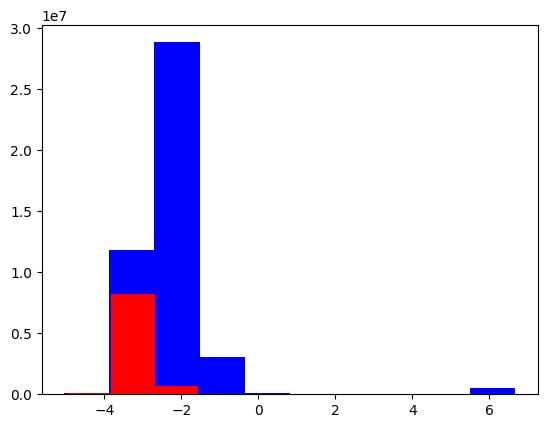

In [49]:
plt.hist(np.log10(source.mHI_g.value), color = 'blue')
plt.hist(np.log10(mHI_g.value), color = 'red')

(array([4.483000e+03, 1.904000e+03, 3.961260e+05, 2.260958e+06,
        2.839780e+06, 2.393704e+06, 9.611610e+05, 1.176960e+05,
        3.608000e+03, 5.900000e+01]),
 array([0.0860364 , 0.55887517, 1.03171394, 1.50455271, 1.97739149,
        2.45023026, 2.92306903, 3.3959078 , 3.86874658, 4.34158535,
        4.81442412]),
 <BarContainer object of 10 artists>)

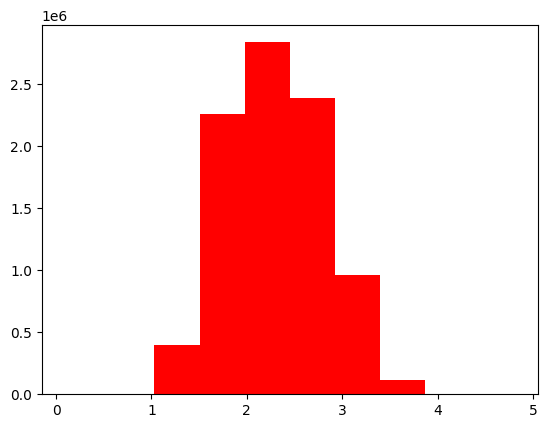

In [51]:
#plt.hist(source.r_cell, color = 'blue')
plt.hist(r_cell, color = 'red')

In [ ]:
 # Let's load the data of the subhalos
    sub_meta = get(subhalos['results'][i]['url'])    
    # --------------------------------------------------------
    if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies

In [36]:
import tempfile
import argparse
import requests
import contextlib
headers = {"api-key": '81b7c70637fa8b110e6b9f236ea07c37'}
gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(0) + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
       

In [71]:
mass= gas_halo[6]*1e10/h
dens = gas_halo[1] * 1e10*h*h
v = mass/dens
r = np.power(3.0 * v / 4.0 / np.pi, 1.0 / 3.0)

(array([6.800000e+01, 1.030985e+06, 6.862452e+06, 1.076541e+06,
        9.335000e+03, 7.100000e+01, 1.800000e+01, 5.000000e+00,
        2.000000e+00, 2.000000e+00]),
 array([ 174429.890625 ,  704256.7015625, 1234083.5125   , 1763910.3234375,
        2293737.134375 , 2823563.9453125, 3353390.75625  , 3883217.5671875,
        4413044.378125 , 4942871.1890625, 5472698.       ]),
 <BarContainer object of 10 artists>)

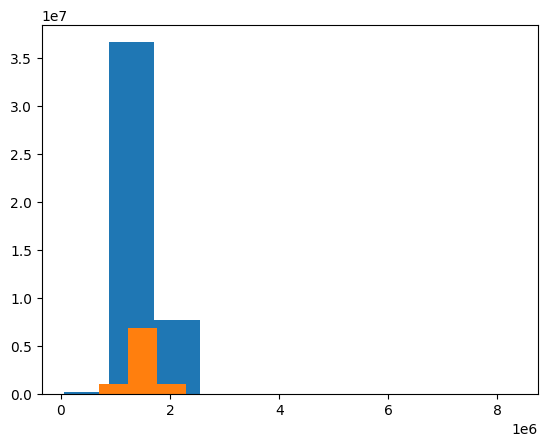

In [73]:
plt.hist(mass)
plt.hist(np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasMasses.txt'))

(array([1.450435e+06, 5.182902e+06, 2.321305e+06, 1.897400e+04,
        9.750000e+02, 1.516000e+03, 1.400000e+03, 1.063000e+03,
        6.870000e+02, 2.220000e+02]),
 array([3.68703367, 4.19321008, 4.6993865 , 5.20556291, 5.71173932,
        6.21791574, 6.72409215, 7.23026856, 7.73644498, 8.24262139,
        8.7487978 ]),
 <BarContainer object of 10 artists>)

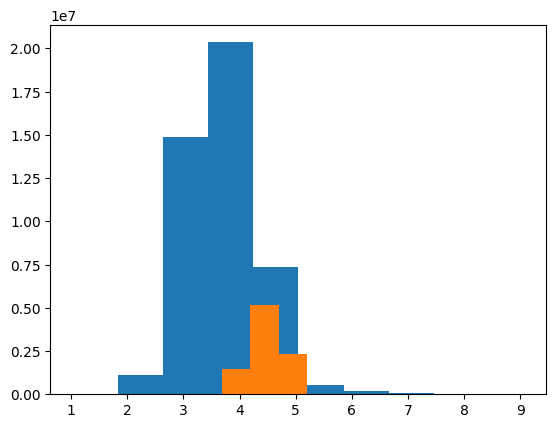

In [78]:
plt.hist(np.log10(dens))
plt.hist(np.log10(np.loadtxt('../data/particles/halo_0_subhalo_0_gasDens.txt') * (1e10) * (h**2)))

(array([2.580000e+02, 7.250000e+02, 1.100000e+03, 1.386000e+03,
        1.502000e+03, 1.154000e+03, 2.206370e+05, 3.436385e+06,
        5.000323e+06, 3.160090e+05]),
 array([-2.57386475, -2.04950611, -1.52514747, -1.00078883, -0.47643019,
         0.04792845,  0.57228709,  1.09664573,  1.62100437,  2.14536301,
         2.66972165]),
 <BarContainer object of 10 artists>)

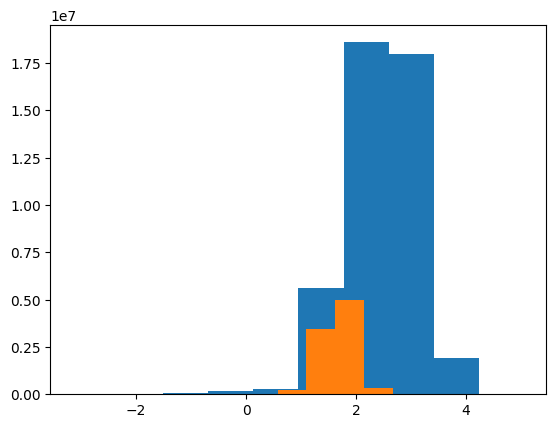

In [87]:
plt.hist(np.log10(v))
v0 = np.loadtxt('../data/particles/halo_0_subhalo_' + str(subID) + '_gasMasses.txt') / (np.loadtxt('../data/particles/halo_0_subhalo_0_gasDens.txt') * (1e10) * (h**2))
plt.hist(np.log10(v0))

(array([4.483000e+03, 1.904000e+03, 3.961260e+05, 2.260958e+06,
        2.839780e+06, 2.393704e+06, 9.611610e+05, 1.176960e+05,
        3.608000e+03, 5.900000e+01]),
 array([0.0860364 , 0.55887517, 1.03171394, 1.50455271, 1.97739149,
        2.45023026, 2.92306903, 3.3959078 , 3.86874658, 4.34158535,
        4.81442412]),
 <BarContainer object of 10 artists>)

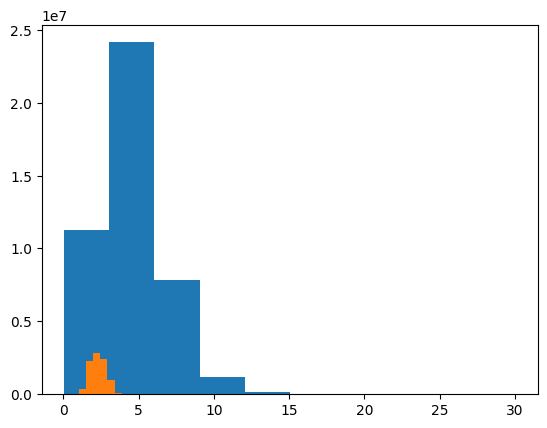

In [88]:
plt.hist(r)
plt.hist(np.power(3.0 * v0 / 4.0 / np.pi, 1.0 / 3.0))

In [89]:
np.power(3.0 * v0 / 4.0 / np.pi, 1.0 / 3.0)

array([0.88631188, 1.00148585, 0.93436139, ..., 0.73601833, 0.72423576,
       0.85415123])

In [24]:
np.sum(mHI_g)

<Quantity 1.00734477e+13 solMass>

In [52]:
# This rotation is to have the same "sky plane" in martini than in skirt
theta = np.pi/2
rot_mat = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])

In [85]:
source0 = SPHSource(
            distance=15 * U.Mpc,
            h=h,
            T_g=T_g,
            mHI_g=mHI_g,
            xyz_g=xyz_g,
            vxyz_g=vxyz_g,
            hsm_g=hsm_g,
            vpeculiar=0 * U.km / U.s,
            #rotation={"rotmat": rot_mat}
        )

In [71]:
print(np.max(source0.coordinates_g.x))
print(np.max(source0.coordinates_g.y))
print(np.max(source0.coordinates_g.z))

print(np.max(source.coordinates_g.x))
print(np.max(source.coordinates_g.y))
print(np.max(source.coordinates_g.z))

737.8135234595738 kpc
369.2409470129527 kpc
372.6755801814941 kpc
1500.3154296875 kpc
394.578369140625 kpc
402.85406494140625 kpc


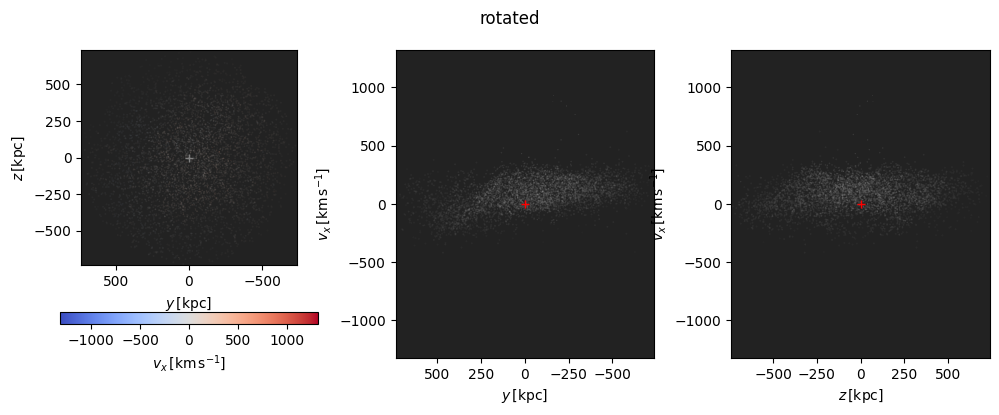

In [54]:
source0.preview(title="rotated")
plt.show()

In [55]:
beam = GaussianBeam(
    bmaj=30.0 * U.arcsec, bmin=30.0 * U.arcsec, bpa=0.0 * U.deg, truncate=3.0
)

In [62]:
datacube = DataCube(
    n_px_x=184,
    n_px_y=184,
    n_channels=50,
    px_size=50.0 * U.arcsec,
    channel_width=6.0 * U.km * U.s**-1,
    velocity_centre=source0.vsys,
    ra=source0.ra,
    dec=source0.dec,
)

In [63]:
noise = GaussianNoise(
    rms=3.0e-8 * U.Jy * U.beam**-1,
    seed=0,
)

In [64]:
spectral_model = GaussianSpectrum(sigma="thermal")

In [65]:
sph_kernel = CubicSplineKernel()

In [66]:
M = Martini(
    source=source,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel,
)

Source module contained 44613679 particles with total HI mass of 5.10e+11 solMass.
Pruned particles that will not contribute to data cube, 9738786 particles remaining with total HI mass of 1.38e+09 solMass.


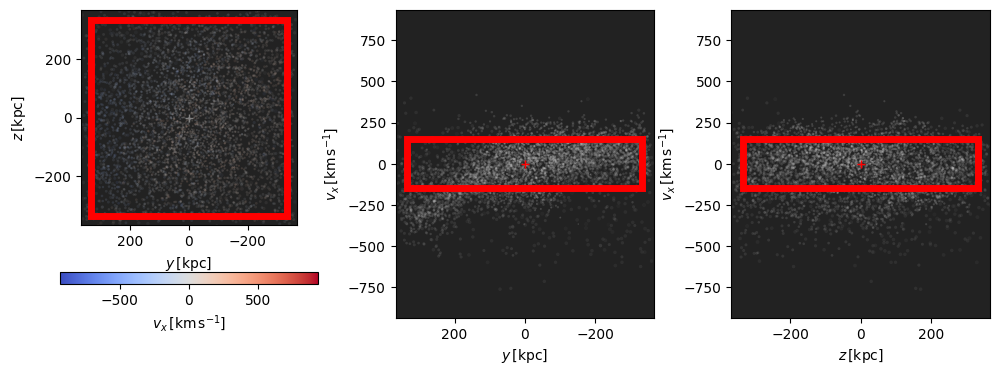

In [67]:
M.preview()
plt.show()

In [60]:
M0 = Martini(
    source=source0,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel,
)

Source module contained 8979479 particles with total HI mass of 3.33e+09 solMass.
Pruned particles that will not contribute to data cube, 4927953 particles remaining with total HI mass of 3.97e+06 solMass.


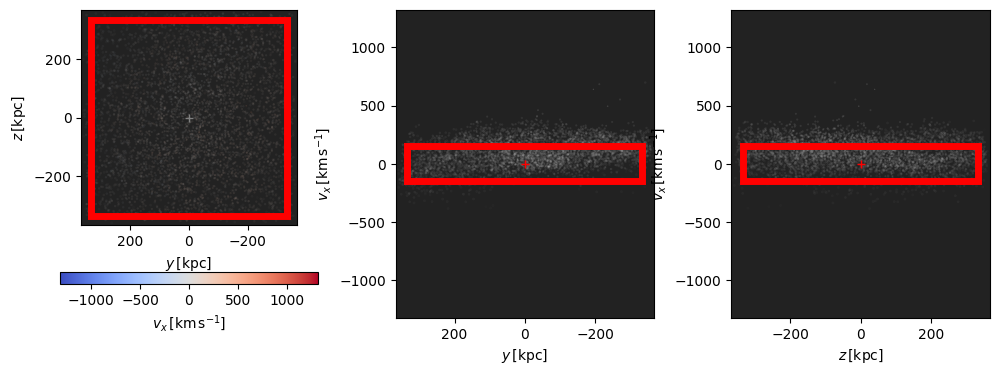

In [61]:
M0.preview()
plt.show()

In [101]:
start = time()
M.insert_source_in_cube(ncpu=1)
M.add_noise()
M.convolve_beam()
stop = time()
print('It took {:.2f} seconds to produce the datacube'.format(stop-start))

100%|██████████| 36100/36100 [3:49:26<00:00,  2.62it/s]  


Source inserted.
  Flux density in cube: 2.46e+00 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 7.85e+08 solMass
    [0% of initial source mass]
  Maximum pixel: 1.99e-05 Jy / arcsec2
  Median non-zero pixel: 2.19e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 2.92e-11 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 4.46e-08 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 4.42e-05 Jy / beam
  Maximum pixel: 1.85e-02 Jy / beam
  Median non-zero pixel: 1.83e-08 Jy / beam
It took 13769.18 seconds to produce the datacube


In [102]:
M.write_fits(folder + "/tng_martini_demo.fits")
M.write_beam_fits(folder + "/tng_martini_demo_beam.fits")
M.write_hdf5(folder + "/tng_martini_demo.hdf5")

In [103]:
from astropy.io import fits
from astropy.wcs import WCS


In [104]:
with fits.open(folder + "/tng_martini_demo.fits") as f:
    cube_wcs = WCS(f[0].header)
    flux_cube = f[0].data * U.Unit(f[0].header["BUNIT"])
    n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
    vch = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
        0
    ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
    vch = vch - source.vsys

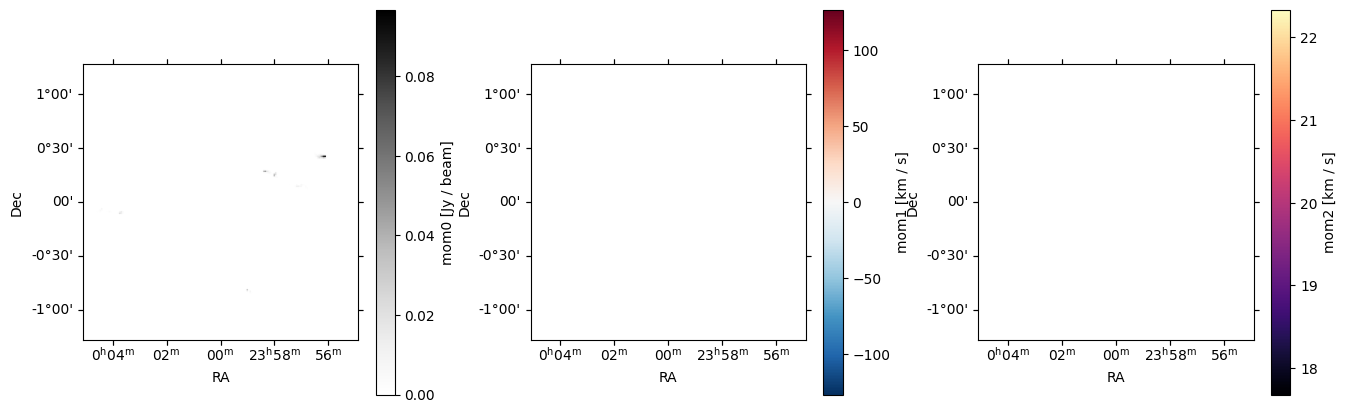

In [105]:
# choose plotting units
mom0_unit = U.Jy / U.beam
mom1_unit = U.km / U.s
mom2_unit = U.km / U.s

rms = np.std(
    flux_cube[:, :16, :16]
)  # noise in a corner patch where there is little signal
clip = np.where(flux_cube > 5 * rms, 1, 0)
np.seterr(all="ignore")
fig = plt.figure(figsize=(16, 5))
plt.clf()
sp1 = fig.add_subplot(1, 3, 1, aspect="equal", projection=cube_wcs.celestial)
sp2 = fig.add_subplot(1, 3, 2, aspect="equal", projection=cube_wcs.celestial)
sp3 = fig.add_subplot(1, 3, 3, aspect="equal", projection=cube_wcs.celestial)
mom0 = np.sum(flux_cube, axis=0)
mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
mom2 = np.sqrt(
    np.sum(
        flux_cube
        * clip
        * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
        axis=0,
    )
    / mom0
)
im1 = sp1.imshow(mom0.to_value(mom0_unit), cmap="Greys")
plt.colorbar(im1, ax=sp1, label=f"mom0 [{mom0_unit}]")
im2 = sp2.imshow(
    (mom1 * mask).to_value(mom1_unit),
    cmap="RdBu_r",
    vmin=-np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
    vmax=np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
)
plt.colorbar(im2, ax=sp2, label=f"mom1 [{mom1_unit}]")
im3 = sp3.imshow(
    (mom2 * mask).to_value(mom2_unit),
    cmap="magma",
)
plt.colorbar(im3, ax=sp3, label=f"mom2 [{mom2_unit}]")
for sp in sp1, sp2, sp3:
    sp.set_xlabel("RA")
    sp.set_ylabel("Dec")

plt.subplots_adjust(wspace=0.3)